# LM-32 - Apprendimento Automatico e Apprendimento Profondo
## Progetto di sviluppo di un progetto di machine/deep learning
## Scatto Alessandro 
## Matricola: 0322500036



Elaborato sviluppato in ambiente Jupyter con Anaconda e stampato con Latex

A seguito di una valutazione per l'elaborato ho scelto Breast Cancer Wisconsin (Diagnostic) 
Il dataset è disponibile nell'archivio UCI e facilmente caricabile tramite scikit-learn 
non ha valori nulli, ed il numero di record non troppo alto ed è adatto ai fini didattici 

Partizionerò i dati in 70% training, 20% Validation e 10% Test che è buon compromesso non essendo il dataset molto grande. 
Con la stratificazione garantisco una distribuzione fedele all'originale in ciascun sottoinsieme


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

#  PREREQUISITO: Caricamento del Dataset Breast Cancer
#  il dataset ha 30 feature ed il target prevede la classe (0=maligno, 1=benigno)
#  grazie al paramentro as_frame=True viene caricato già in formato DataFrame
dataset = load_breast_cancer(as_frame=True)
df = dataset.frame

# Separazione Feature (X) e Target (y)
X = dataset.data  # DataFrame delle feature
y = dataset.target  # Serie della variabile target

print("DataFrame caricato. Eseguo un controllo sui valori nulli:")
print(X.isnull().sum().sum()) # Stampa 0 se non ci sono valori nulli

# Suddivido Training, Validation e Test con le librerie di scikit-learn 
# Suddivido  in Train (70%) e temp (30%) per dividere poi Test e Validation 
# faccio la stratificazione
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Suddivido il set temporaneo in Validation (20%) e Test (10%) buon compromesso non essendo il dataset molto grande
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp
)

#  effettuo la Standardizzazione dei Dati (operazione molto importante per PCA, LogReg, e SVM)
scaler = StandardScaler()

# Addestro lo scaler solo sui dati di TRAIN
X_train_scaled = scaler.fit_transform(X_train)

# Trasformo tutti i set (usando lo scaler addestrato)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nStampo le dimensioni dei Set per verificare l'effetto dello split:")
print(f"Training set: {X_train_scaled.shape}")
print(f"Validation set: {X_val_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

DataFrame caricato. Eseguo un controllo sui valori nulli:
0

Stampo le dimensioni dei Set per verificare l'effetto dello split:
Training set: (398, 30)
Validation set: (114, 30)
Test set: (57, 30)


# --- 1. Analisi delle feature e implementazione dell’algoritmo PCA ---

in questa fase lo scopo è trovare le componenti principalie se possibile ridurre la dimensionalità
individuando eventuali ridondanze e multicollinearità

In [2]:
# --- 1. Analisi delle feature e implementazione dell’algoritmo PCA ---
# Applico la PCA solo sul set di TRAIN SCALATO
# Inizialmente calcolo tutte le 30 feature principali (n_components=None)
pca = PCA(n_components=None) 
pca.fit(X_train_scaled)

# Trasformo il set di TRAIN
X_train_pca = pca.transform(X_train_scaled)

# --- ANALISI DELLA VARIANZA SPIEGATA ---
# Calcolo della varianza spiegata cumulativa
varianza_cumulativa = np.cumsum(pca.explained_variance_ratio_)

# cerco quante componenti servono per spiegare il 95% della varianza, in modo da rilevare multicollinearità o variabili superflue 
# np.argmax trova il primo indice in cui la condizione è soddisfatta
n_95 = np.argmax(varianza_cumulativa >= 0.95) + 1 # +1 perché gli indici partono da 0

print(f"Componenti necessarie per spiegare il 95% della varianza: {n_95}")



Componenti necessarie per spiegare il 95% della varianza: 10


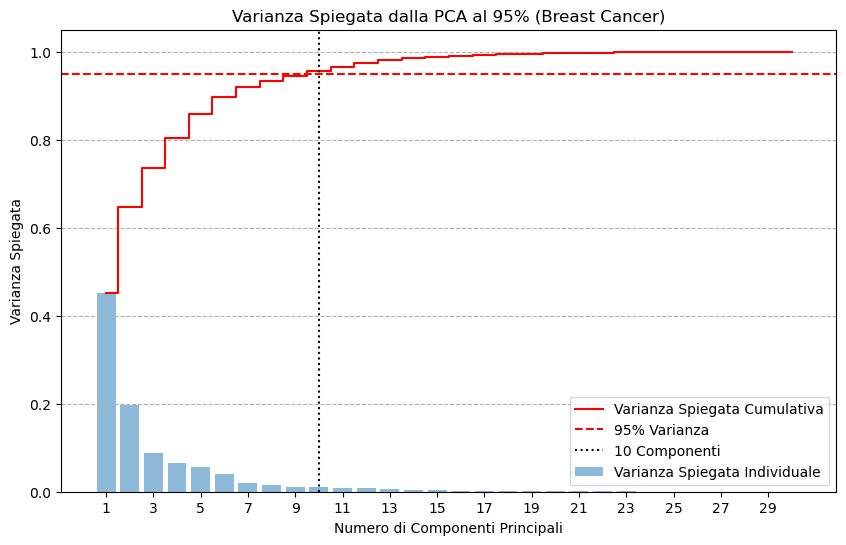

In [3]:
# Creo lo Scree Plot per visualizzare la Varianza Spiegata
plt.figure(figsize=(10, 6))

# Varianza Spiegata per Componente
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 
        alpha=0.5, align='center', label='Varianza Spiegata Individuale')

# Varianza Spiegata Cumulativa
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), varianza_cumulativa, 
         where='mid', label='Varianza Spiegata Cumulativa', color='red')

# Linea per il 95% (obiettivo)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Varianza')

# Linea verticale per il numero di componenti a 95%
plt.axvline(x=n_95, color='k', linestyle=':', label=f'{n_95} Componenti')

plt.xlabel('Numero di Componenti Principali')
plt.ylabel('Varianza Spiegata')
plt.title('Varianza Spiegata dalla PCA al 95% (Breast Cancer)')
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--')
plt.xticks(range(1, 31, 2))
plt.show()

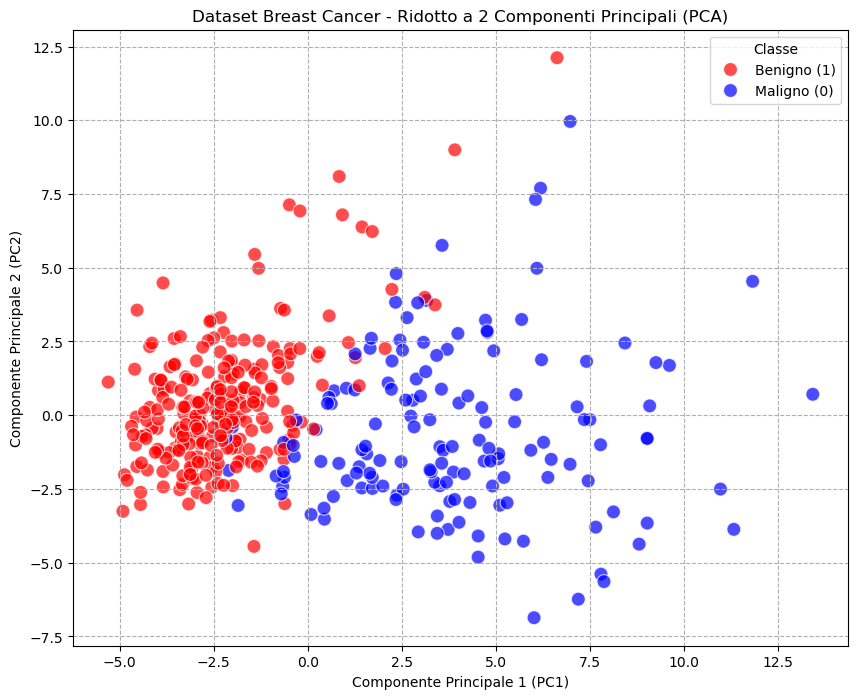

In [4]:
# PCA con 2 componenti per visualizzare la separazione delle classi
pca_2d = PCA(n_components=2)
pca_2d.fit(X_train_scaled)

# Trasformiamo i dati di TRAIN nel nuovo spazio 2D
X_train_2d = pca_2d.transform(X_train_scaled)

# Creiamo un DataFrame per la visualizzazione con Matplotlib/Seaborn
df_pca = pd.DataFrame(data=X_train_2d, columns=['PC1', 'PC2'])
df_pca['Target'] = y_train.values # Aggiungo il target (0: Maligno, 1: Benigno)

# Mappa per etichettare meglio le classi
target_names = {0: 'Maligno (0)', 1: 'Benigno (1)'}
df_pca['Target Label'] = df_pca['Target'].map(target_names)

# Plotting con Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1", 
    y="PC2", 
    hue="Target Label", # Colora in base al target
    data=df_pca,
    palette=['red', 'blue'], # Colori scelti
    s=100, # Dimensione dei punti
    alpha=0.7 # Trasparenza
)
plt.title('Dataset Breast Cancer - Ridotto a 2 Componenti Principali (PCA)')
plt.xlabel('Componente Principale 1 (PC1)')
plt.ylabel('Componente Principale 2 (PC2)')
plt.grid(True, linestyle='--')
plt.legend(title='Classe')
plt.show()

In [5]:
# Ricalcolo la PCA con il numero ottimale di componenti
pca_final = PCA(n_components=n_95)
X_train_pca_final = pca_final.fit_transform(X_train_scaled)

# Trasformo tutti i set usando la PCA addestrata sul Training Set
X_test_pca_final = pca_final.transform(X_test_scaled)
X_val_pca_final = pca_final.transform(X_val_scaled)

print(f"La dimensione dei dati di Training è stata ridotta da 30 a {X_train_pca_final.shape[1]} feature.")
print(f"Nuova dimensione del Training Set (PC): {X_train_pca_final.shape}")


La dimensione dei dati di Training è stata ridotta da 30 a 10 feature.
Nuova dimensione del Training Set (PC): (398, 10)


# --- 2. Implementazione di almeno tre degli algoritmi di classificazione ---

utilizzerò

Regressione Logistica > per vedere come un modello lineare gestisce la separabilità del dataset

Support Vector Machine (SVM) > da letteratura molto efficace sul dataset Breast Cancer

Random Forest > resiste bene all'overfitting, utilizza gli alberi decisionali quindi trasparente e spiegabile

K-Nearest Neighbors (KNN) > ha un approccio diverso  basato sulla "vicinanza dei vicini"

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# --- 2. Implementazione di almeno tre degli algoritmi di classificazione ---
# --- INIZIALIZZAZIONE DEI MODELLI ---
models = {
    'Logistic Regression (LogReg)': LogisticRegression(solver='liblinear', random_state=42),
    
    # probability=True è necessario per calcolare la ROC AUC
    'Support Vector Machine (SVM)': SVC(kernel='rbf', gamma='auto', random_state=42, probability=True), 
    
    'Random Forest (RF)': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    
    # K=5 è un valore tipico e robusto per l'inizializzazione
    'K-Nearest Neighbors (KNN)': KNeighborsClassifier(n_neighbors=5) 
}

# Dizionario per memorizzare i modelli addestrati
trained_models = {}
results = {}

print("--- Punto 2: Addestramento e Valutazione Iniziale (PCA Features) ---")

# Addestramento e predizione
for name, model in models.items():
    
    # Addestramento sul set di Training PCA
    model.fit(X_train_pca_final, y_train)
    trained_models[name] = model # Salva il modello addestrato
    
    # Predizione sul set di Test PCA
    y_pred = model.predict(X_test_pca_final)
    

--- Punto 2: Addestramento e Valutazione Iniziale (PCA Features) ---


# --- 3. Implementazione del calcolo delle metriche di valutazione precision, recall, f-measure Accuracy, Roc AUC ---

Dopo aver addestrato e testato ciascun modello, andiamo a calcolare le metriche richieste sul Test Set.
il tutto grazie alle librerie sklearn.metrics

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 3. Implementazione del calcolo delle metriche di valutazione precision, recall, f-measure Accuracy, Roc AUC ---

metriche_complete = {}

print("--- Punto 3: Calcolo delle Metriche di Valutazione ---")

for name, model in trained_models.items():
    
    # a. Predizioni Classi (necessarie per Accuracy, Precision, Recall, F1)
    y_pred = model.predict(X_test_pca_final)
    
    # b. Predizioni Probabilità (necessarie per ROC AUC)
    # Se il modello non ha .predict_proba (es. alcuni kernel SVM senza probability=True), usiamo decision_function.
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_pca_final)[:, 1] # Probabilità della classe positiva (1 - Benigno)
    elif hasattr(model, "decision_function"):
        # Per SVM se probability=False
        y_prob = model.decision_function(X_test_pca_final)
    else:
        y_prob = None
        print(f"Attenzione: {name} non supporta la predizione di probabilità per ROC AUC.")

    # c. Calcolo delle metriche
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # ROC AUC
    if y_prob is not None:
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = None

    # Memorizzazione dei risultati
    metriche_complete[name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Measure': f1,
        'ROC AUC': roc_auc,
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    print(f"\nRisultati {name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    print(f"  F1-Measure: {f1:.4f}")
    if roc_auc is not None:
        print(f"  ROC AUC: {roc_auc:.4f}")
    
# Converto i risultati in un DataFrame per una visualizzazione chiara
df_metriche = pd.DataFrame({k: {m: v for m, v in val.items() if m not in ['y_pred', 'y_prob']} 
                            for k, val in metriche_complete.items()}).T
print("\n--- TABELLA RIASSUNTIVA DELLE METRICHE ---")
print(df_metriche.round(4))

--- Punto 3: Calcolo delle Metriche di Valutazione ---

Risultati Logistic Regression (LogReg):
  Accuracy: 0.9649
  Precision: 0.9722
  Recall: 0.9722
  F1-Measure: 0.9722
  ROC AUC: 0.9934

Risultati Support Vector Machine (SVM):
  Accuracy: 0.9649
  Precision: 0.9722
  Recall: 0.9722
  F1-Measure: 0.9722
  ROC AUC: 0.9934

Risultati Random Forest (RF):
  Accuracy: 0.9474
  Precision: 0.9231
  Recall: 1.0000
  F1-Measure: 0.9600
  ROC AUC: 0.9881

Risultati K-Nearest Neighbors (KNN):
  Accuracy: 0.9474
  Precision: 0.9231
  Recall: 1.0000
  F1-Measure: 0.9600
  ROC AUC: 0.9729

--- TABELLA RIASSUNTIVA DELLE METRICHE ---
                              Accuracy  Precision  Recall  F1-Measure  ROC AUC
Logistic Regression (LogReg)    0.9649     0.9722  0.9722      0.9722   0.9934
Support Vector Machine (SVM)    0.9649     0.9722  0.9722      0.9722   0.9934
Random Forest (RF)              0.9474     0.9231  1.0000      0.9600   0.9881
K-Nearest Neighbors (KNN)       0.9474     0.9231  1.0

# --- 4) Implementazione della visualizzazione della matrice di confusione e della ROC AUC Curve ---

Utilizziamo matplot per stampare le Confusion Matrix
ed il grafico ROC AUC che è una buona metrica per valutare la capacità del modello di distinguere tra le classi,
indipendentemente dalla soglia di classificazione.

--- 4.1: Visualizzazione delle Matrici di Confusione ---


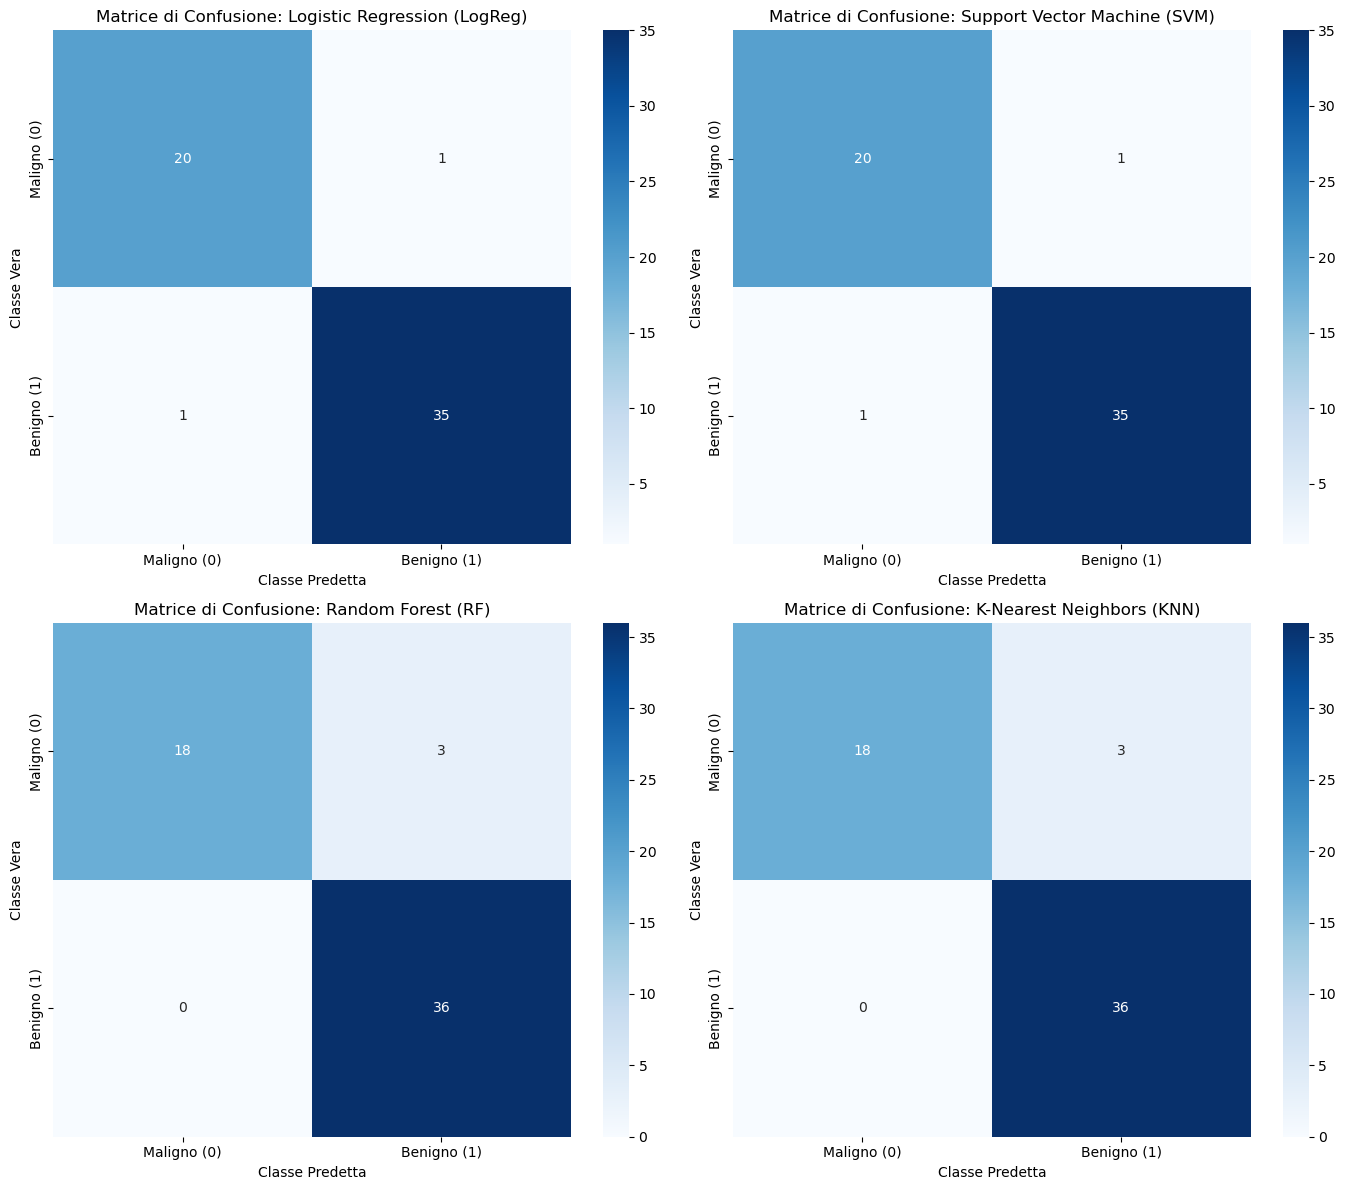

In [8]:
# 4.1. Visualizzazione delle Matrici di Confusione per tutti i 4 modelli

# Dizionario per i nomi delle etichette (più chiare per il plot)
target_labels = {0: 'Maligno (0)', 1: 'Benigno (1)'}

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten() # Rende gli assi accessibili in un array 1D

print("--- 4.1: Visualizzazione delle Matrici di Confusione ---")

# con un ciclo stampo le matrici di tutti i modelli utilizzati
for i, (name, metrics) in enumerate(metriche_complete.items()):
    
    y_pred = metrics['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot della matrice
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_labels.values(), 
                yticklabels=target_labels.values(),
                ax=axes[i])
    # ogni matrice con il la sua intestazione di modello
    axes[i].set_title(f'Matrice di Confusione: {name}')
    axes[i].set_ylabel('Classe Vera')
    axes[i].set_xlabel('Classe Predetta')

plt.tight_layout()
plt.show()

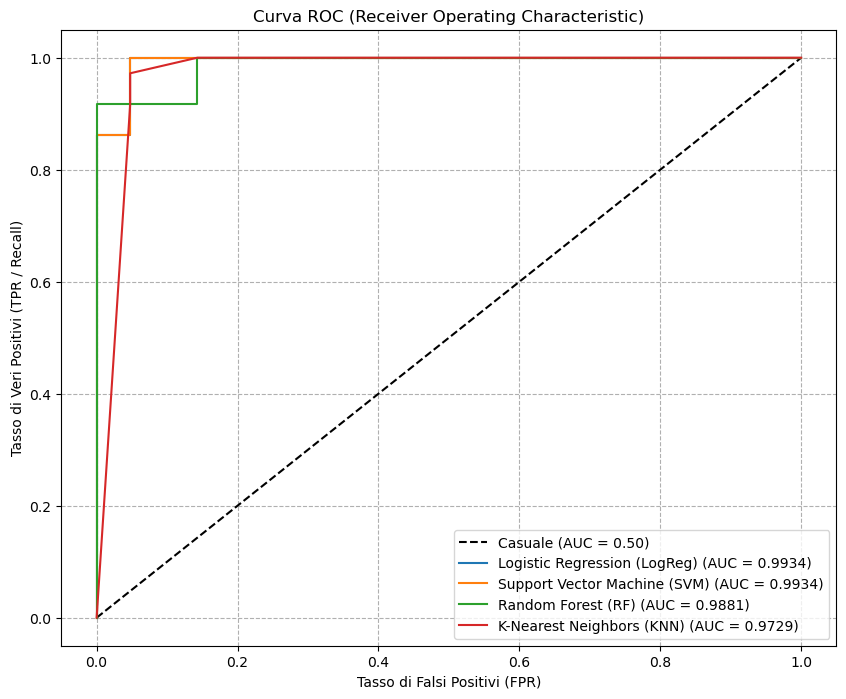

In [9]:
# --- ROC AUC Curve ---

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Casuale (AUC = 0.50)')

for name, metrics in metriche_complete.items():
    y_prob = metrics['y_prob']
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        auc = metrics['ROC AUC']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

plt.xlabel('Tasso di Falsi Positivi (FPR)')
plt.ylabel('Tasso di Veri Positivi (TPR / Recall)')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--')
plt.show()

# --- 5 Implementazione di un approccio di spiegabilità scelto tra SHAP o LIME

ho selezionato SHAP (SHapley Additive exPlanations) e lo effettup su Logistic Regression che assieme a SVM si è rivelato tra i migliori
questo aiuta a capire perché il  modello prende determinate decisioni
ci dirà quanto ogni Componente Principale ha contribuito alla predizione.

--- Punto 5b: Spiegabilità con SHAP per Logistic Regression (LogReg) ---




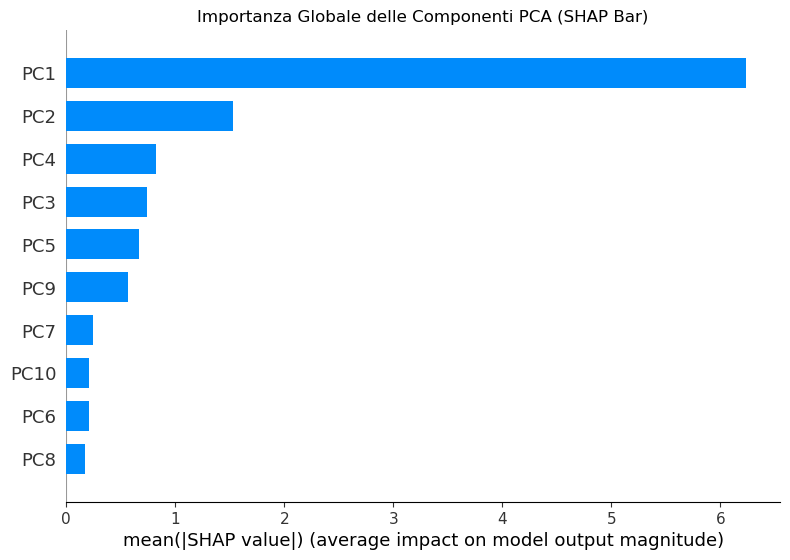

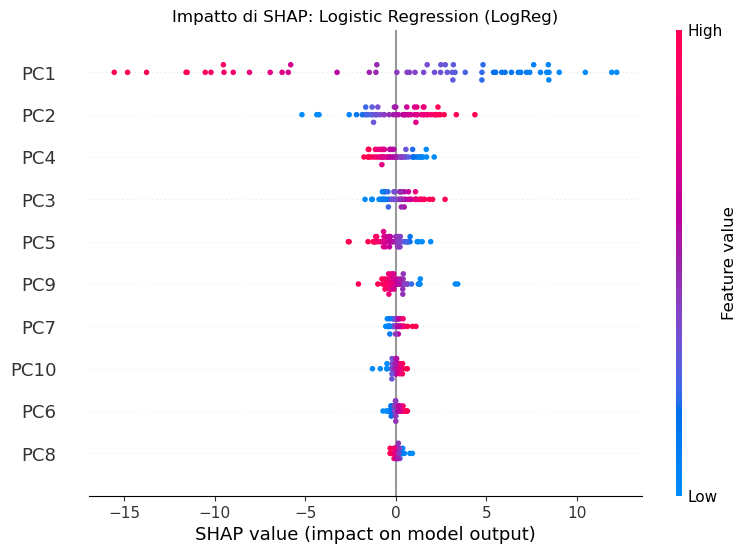

In [10]:
import shap 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# --- 5 Implementazione dell'approccio di spiegabilità SHAP

# 1. Scegliere il modello e i dati
best_model_name = 'Logistic Regression (LogReg)' 
best_model = trained_models[best_model_name]

print(f"--- Punto 5b: Spiegabilità con SHAP per {best_model_name} ---")

# 2. Inizializzare l'Explainer
# Per i modelli lineari come Logistic Regression, si usa LinearExplainer
explainer = shap.LinearExplainer(
    best_model, 
    # SHAP ha bisogno di un set di dati di background per la sua spiegazione (usiamo il Training Set)
    X_train_pca_final 
)

# 3. Preparare i dati di Test per il calcolo
# Dati di test in formato array NumPy
X_test_pca_numpy = X_test_pca_final 

# Per le visualizzazioni SHAP, creiamo un DataFrame con i nomi delle componenti
n_features = X_test_pca_final.shape[1]
feature_names = [f'PC{i+1}' for i in range(n_features)]
X_test_pca_df = pd.DataFrame(X_test_pca_numpy, columns=feature_names) 

# 4. Calcolare i valori SHAP
# I valori SHAP qui sono in log-odds (scala del modello lineare)
shap_values = explainer.shap_values(X_test_pca_numpy) 

# --- 5. Visualizzazione Globale (Feature Importance - Bar Plot) ---
# Mostra l'importanza media assoluta di ogni componente sulla predizione.
print("\n")
shap.summary_plot(shap_values, X_test_pca_df, plot_type="bar", show=False)
plt.title(f"Importanza Globale delle Componenti PCA (SHAP Bar)")
plt.show()

# --- 6. Visualizzazione Dettagliata (Feature Impact - Beeswarm Plot) ---
# Mostra la distribuzione dell'impatto di ogni componente. 
# Il colore rappresenta il valore della feature (ad esempio, alto vs. basso)
print("\n")
shap.summary_plot(shap_values, X_test_pca_df, show=False)
plt.title(f"Impatto di SHAP: {best_model_name}")
plt.show()

# --- 5b Implementazione di un approccio di deep learning sugli stessi dati --

sullo steso dataset utilizzato per gli algoritmi shallow ho provato ad utilizzare un modello di Deep Learning
DNN tensorflow

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# --- sugli stessi dati utilizzati per gli algoritmi shallow 
# con la stessa suddivisione di training, validation e test utilizzato per gli esperimenti precedenti

# Numero di feature (componenti PCA) dopo la riduzione
input_features = X_train_pca_final.shape[1] 

# 1. Definizione della Rete Neurale (DNN)
model_dl = Sequential([
    # LAYER 1: Input Layer (Definisce la forma dell'input)
    # Questa è la correzione che elimina l'UserWarning
    Input(shape=(input_features,)), 
    
    # LAYER 2: Primo Layer DENSE
    Dense(32, activation='relu'), 
    
    # Hidden Layer
    Dense(16, activation='relu'),
    
    # Output Layer (1 neurone con sigmoid per classificazione binaria)
    Dense(1, activation='sigmoid')
])

# 2. Compilazione del Modello
model_dl.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

print("--- Riepilogo Architettura Deep Learning ---")
model_dl.summary()

# 3. Addestramento del Modello
print("\n--- Addestramento del Modello DNN ---")
# Usiamo il set di Validation per monitorare l'overfitting
history = model_dl.fit(
    X_train_pca_final, 
    y_train, 
    epochs=50,             
    batch_size=32,         
    validation_data=(X_val_pca_final, y_val), # USA IL VALIDATION SET
    verbose=1 # Mostra l'output dell'addestramento
)

# 4. Valutazione sul Test Set
loss, accuracy = model_dl.evaluate(X_test_pca_final, y_test, verbose=0)
y_prob_dl = model_dl.predict(X_test_pca_final).flatten()
roc_auc_dl = roc_auc_score(y_test, y_prob_dl)

print(f"\nRisultati Deep Learning sul Test Set:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  ROC AUC: {roc_auc_dl:.4f}")

--- Riepilogo Architettura Deep Learning ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897 (3.50 KB)

 Trainable params: 897 (3.50 KB)

 Non-trainable params: 0 (0.00 B)


--- Addestramento del Modello DNN ---
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7588 - loss: 0.5957 - val_accuracy: 0.7895 - val_loss: 0.5520
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8970 - loss: 0.4617 - val_accuracy: 0.9123 - val_loss: 0.4367
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9271 - loss: 0.3639 - val_accuracy: 0.9386 - val_loss: 0.3497
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9447 - loss: 0.2919 - val_accuracy: 0.9561 - val_loss: 0.2874
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9598 - loss: 0.2383 - val_accuracy: 0.9561 - val_loss: 0.2384
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9623 - loss: 0.1989 - val_accuracy: 0.9561 - val_loss: 0.2008
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9749 - loss: 0.1685 - val_accuracy: 0.9649 - val_loss: 0.1709
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9749 - l

# --- Discussione finale dei risultati e conclusioni---

L'algoritmo PCA ha dimostrato che le 30 feature originali del dataset Breast Cancer erano altamente correlate e ridondanti. 
Siamo riusciti a catturare il 95% della varianza dei dati utilizzando solo 10 feature principali 
evitando overfitting e rendendo più veloce l'addestramento dei modelli

La visualizzazione in 2D (PC1 vs. PC2) ha confermato che le classi (Maligno e Benigno) sono linearmente separabili nello spazio ridotto, il che è un forte indicatore di alta performance attesa.

La performance generale è molto alta: 
Tutti gli algoritmi hanno raggiunto un livello di performance eccezionalmente alto (Accuracy tra il 0,94 ed il 0,97, ROC AUC > 0.97). 
Confermando la separabilità del dataset Breast Cancer

La Regressione Logistica ha ottenuto risultati molto buoni, anche in confronto  a modelli più complessi come Random Forest e SVM. 
Questo suggerisce che la separazione tra le classi è prevalentemente lineare rendendo superflua la complessità aggiuntiva di un kernel o di un modello ensemble. Ha dimostrato inoltre un ottimo bilanciamento tra Precision e Recall evitando falsi negativi.

Deep Learning vs. Shallow: il Tensorflow (DNN) non ha superato né  eguagliato i risultati della LogReg. 
Questo era prevedibile visto la dimensione moderata del dataset, gli algoritmi shallow rimangono una soluzione efficiente.

Il risultato finale è un modello semplice, veloce,  preciso e completamente spiegabile, ideale per un'applicazione in un contesto clinico.
